In [17]:
import numpy as np #basic python library
import matplotlib.pyplot as plt #For plotting results

## Import Landlab components
from landlab.components import DepressionFinderAndRouter #Pit filling
from landlab.components import PriorityFloodFlowRouter #Flow routing
from landlab.components import FlowAccumulator #FlowAccumulator 
from landlab.components import ChiFinder
from landlab.components import SteepnessFinder
from landlab.components import StreamPowerEroder
from landlab.components import ChannelProfiler 
from landlab.components import SteepnessFinder


#Channel Profiler model
from landlab.components import FastscapeEroder #calculates the amount of erosion at each node
from landlab.components import SinkFillerBarnes #replaces pits with shallow gradients for draining

## Import Landlab utilities
from landlab import RasterModelGrid #Grid utility
from landlab import imshow_grid #For plotting results
from landlab.io import read_esri_ascii #to read in an ascii file
from landlab.io import read_asc_header #to read in the header of the ascii file

[403157]


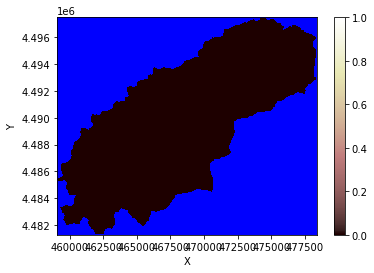

In [18]:
#Set directory paths to retrieve the asc file
path_project = r"C:/Users/gsbir/Documents/EES_393/" # add the path to the asc file    #this should access my H drive
filename_dem = "saucon_txt.txt" #the name of the ascii file
path_dem = path_project + filename_dem #gets the entire path to the ascii file

#now read the header of the asc file (where there is ncols nrows cell size and nodata value) into the string variable dem_header
dem_header = read_asc_header(open(path_dem, 'r'))
#use the above to see your grid dimensions, what the no data value is etc...

#generate new grid and add DEM values into 'topographic__elevation'
(mg, z) = read_esri_ascii(path_dem, name= 'topographic__elevation', halo = 1)


#set the watershed boundary condition and the function returns a integer which is the outlet_id so this is set equal to a variable so we can view this
outlet_id = mg.set_watershed_boundary_condition(z, nodata_value = -9999, return_outlet_id=True)
#This should find your outlet node automatically and outlet_id will be empty if a single outlet was not found

print(outlet_id) #prints out the outlet_id

#print(mg.number_of_nodes) 

#print(mg.at_node.keys()) #Shows the node attributes
#print(mg.corners_at_left_edge)

#this line can look at the boundary status of the nodes to see where the outlet is
#imshow_grid(mg, mg.status_at_node, color_for_closed = 'purple')

# %% Hydrologically condition DEM (fill sinks)
sfb = SinkFillerBarnes(mg, surface=z, method='D8', fill_flat=False) #creating an instance of sinkfillerbarnes 
sfb.run_one_step() #This is important to ensure that your future flow routing will work properly. - run the sinkfiller barnes once

imshow_grid(mg, mg.status_at_node, color_for_closed = 'blue') #creates a graph showing the red and the closed boundaries are set to blue, black is the landscape and white is the outlet ID (cannot see it at this level)

In [19]:
#Set grid parameters 
#these numbers are taken from the ascii header file
num_rows = 712
num_columns = 595
node_next_to_outlet = num_columns + 1
node_spacing = 27.097698258644

In [20]:
# Original K_sp value is 1e-5
K_sp = 1.0e-5  # units vary depending on m_sp and n_sp
m_sp = 0.5  # exponent on drainage area in stream power equation
n_sp = 1.0  # exponent on slope in stream power equation


fr = FlowAccumulator(mg)
spr = StreamPowerEroder(mg, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp, threshold_sp = 0.0)

theta = m_sp / n_sp
sf = SteepnessFinder(mg, reference_concavity = theta, min_drainage_area = 1000.0)

cf = ChiFinder(mg,min_drainage_area=1000.0,reference_concavity=theta, use_true_dx=True)

uplift_rate = .0001 #m/year


Now to run the model

In [21]:
#Set model timestep
timestep = 1 #years

#Set model run time
run_time = 2 #years

#Set elapsed time to zero
elapsed_time = 0

uplift_per_timestep = uplift_rate * timestep 

#Set timestep count to zero
count = 0

while elapsed_time < run_time: #time units of years
    mg.at_node['topographic__elevation'] = mg.at_node['topographic__elevation'] + uplift_per_timestep
    fr.run_one_step() # route flow
    spr.run_one_step(timestep) # fluvial incision
   
    elapsed_time += timestep
    print(count)
    count +=1



0
1


In [29]:
prf = ChannelProfiler(mg,
                      number_of_watersheds=1,
                      main_channel_only=True,
                      minimum_channel_threshold=node_spacing**2)

prf.run_one_step()

Text(0.5, 1.0, '$K_{sp}$=1e-05; $time$=2 yr; $dx$=27.097698258644 m')

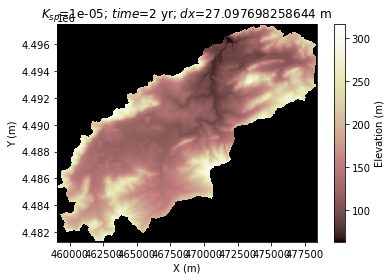

In [30]:
imshow_grid(mg, "topographic__elevation", grid_units=("m", "m"), var_name="Elevation (m)")
title_text = f"$K_{{sp}}$={K_sp}; $time$={elapsed_time} yr; $dx$={node_spacing} m"
plt.title(title_text)


Text(0.5, 1.0, '$K_{sp}$=1e-05; $time$=2 yr; $dx$=1 m')

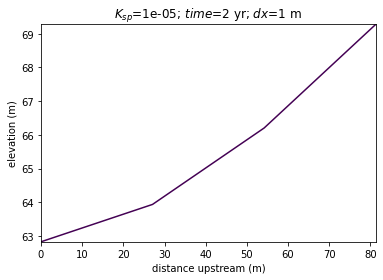

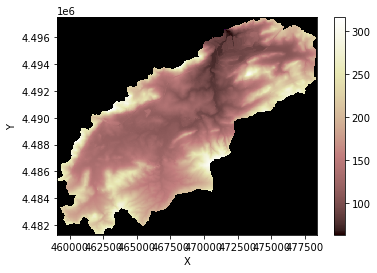

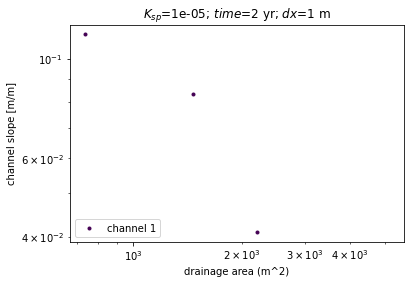

In [31]:
# plot the elevation as a function of distance upstream
plt.figure(1)
title_text = f"$K_{{sp}}$={K_sp}; $time$={elapsed_time} yr; $dx$={timestep} m"
prf.plot_profiles(xlabel='distance upstream (m)',
                  ylabel='elevation (m)',
                  title=title_text)

# plot the location of the channels in map view
plt.figure(2)
prf.plot_profiles_in_map_view()

# slope-area data in just the profiled channels
plt.figure(3)
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.loglog(
            mg.at_node["drainage_area"][profile_ids],
            mg.at_node["topographic__steepest_slope"][profile_ids],
            '.',
            color=color,
            label=label,
        )

plt.legend(loc="lower left")
plt.xlabel("drainage area (m^2)")
plt.ylabel("channel slope [m/m]")
title_text = f"$K_{{sp}}$={K_sp}; $time$={elapsed_time} yr; $dx$={timestep} m"
plt.title(title_text)

Text(0.5, 1.0, '$K_{sp}$=1e-05; $time$=2 yr; $dx$=1 m; concavity=0.5')

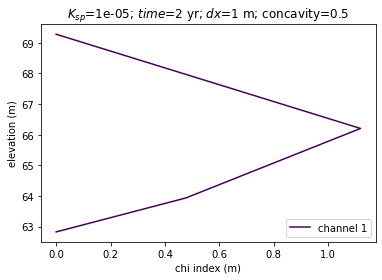

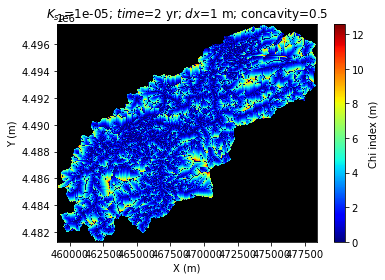

In [32]:
# Code Block 11

# calculate the chi index
cf.calculate_chi()

# chi-elevation plots in the profiled channels
plt.figure(4)

for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.plot(
            mg.at_node["channel__chi_index"][profile_ids],
            mg.at_node["topographic__elevation"][profile_ids],
            color=color,
            label=label,
        )

plt.xlabel("chi index (m)")
plt.ylabel("elevation (m)")
plt.legend(loc="lower right")
title_text = f"$K_{{sp}}$={K_sp}; $time$={elapsed_time} yr; $dx$={timestep} m; concavity={theta}"
plt.title(title_text)

# chi map
plt.figure(5)
imshow_grid(
    mg,
    "channel__chi_index",
    grid_units=("m", "m"),
    var_name="Chi index (m)",
    cmap="jet",
)
title_text = f"$K_{{sp}}$={K_sp}; $time$={elapsed_time} yr; $dx$={timestep} m; concavity={theta}"
plt.title(title_text)

Text(0.5, 1.0, '$K_{sp}$=1e-05; $time$=2 yr; $dx$=1 m; concavity=0.5')

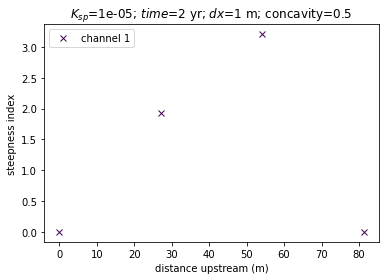

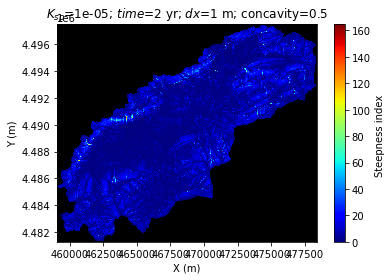

In [33]:
# Code Block 12

# calculate channel steepness
sf.calculate_steepnesses()

# plots of steepnes vs. distance upstream in the profiled channels
plt.figure(6)

for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = "channel {i}".format(i=i + 1)
        else:
            label = '_nolegend_'
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        distance_upstream = segment["distances"]
        color = segment["color"]
        plt.plot(
            distance_upstream,
            mg.at_node["channel__steepness_index"][profile_ids],
            'x',
            color=color,
            label=label,
        )

plt.xlabel("distance upstream (m)")
plt.ylabel("steepness index")
plt.legend(loc="upper left")
plt.title(
    f"$K_{{sp}}$={K_sp}; $time$={elapsed_time} yr; $dx$={timestep} m; concavity={theta}"
)

# channel steepness map
plt.figure(7)
imshow_grid(
    mg,
    "channel__steepness_index",
    grid_units=("m", "m"),
    var_name="Steepness index ",
    cmap="jet",
)
title_text = ("$K_{sp}$=" + str(K_sp) + "; $time$=" + str(elapsed_time) +
              "yr; $dx$=" + str(timestep) + "m" + "; concavity=" + str(theta))
plt.title(
    f"$K_{{sp}}$={K_sp}; $time$={elapsed_time} yr; $dx$={timestep} m; concavity={theta}"
)